# Comic Ray simulation for INCOM


In [1]:
# Python imports
%matplotlib inline 
%matplotlib ipympl
    
import IPython
import heapq
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sympy import symbols, solve
from scipy.interpolate import interp1d
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import itertools
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import norm

C:\Users\Owner\anaconda3\envs\8820-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Constants
m = [5.1e5,0.938e9] # masses of the electron and the proton in eV
z = 1  # charge number for a proton

# Bethe-Bloch equation function
def bb_eqn(vel):
    return 1

# Simulation parameters
lambda_value = 1  # expected number of hits per event
grid_size = 8  # Number of pixels along x & y
cell_size = 10  # Size of each pixel in micrometers (analogous to pixel pitch)
cell_depth = 5  # Depth of each pixel in micrometers (analogous to pixel thickness)
num_samples = 3  # Number of events (can potentially use samples as a proxy for total dt, t_exp)

# User-defined step sizes (in micrometers)
step_size = 0.1 #step size for dx and dy

# Sampling from Poisson distribution
poisson_samples = np.random.poisson(lambda_value, num_samples)

# Starting and ending kinetic energy of particles
E_min = 1e2    # 100 MeV in MeV
E_max = 1e5   # 100 GeV in MeV

# Constants
me = 0.5109989461  # Electron mass (MeV/c^2)
re = 2.8179403227e-13  # Classical electron radius (cm)
NA = 6.02214076e23  # Avogadro's number (1/mol)
c = 2.99792458e10  # Speed of light (cm/s)
K = 0.307075  # MeV cm^2/mol (constant in Bethe formula)

# Material properties (Example: Silicon)
Z_material = 14  # Atomic number of material
A_material = 28.0855  # Atomic mass of material (g/mol)
I = 173e-6  # Mean excitation potential (MeV)
density = 2.3290  # Density of material (g/cm^3)

# Particle properties
Z_particle = 1  # Charge number of the particle
M = 938.27208816  # Mass of the particle (MeV/c^2), example for proton


SID_ranges = [(2000,3999), (4000,5999), (6000,7999), (8000,9999), (10000,11999), (12000,13999), (14000,15999), (16000,17999), (18000,19999), (20000,21999), (22000,23999), (24000,25999), (26000,27999), (28000,29999), (30000,31999), (32000,33999), (34000,35999), (36000,37999), (38000,39999), (40000,41999), (42000,43999), (44000,45999), (46000,47999), (48000,49999)]
color_list = [('sea green', '#53fca1'),('periwinkle','#8e82fe'),('dark pink','#cb416b'),('olive green','#677a04'),('peach','#ffb07c'),('pale green','#c7fdb5'),('light brown','#ad8150'),('hot pink','#ff028d'),('burgundy','#610023'),('lilac','#cea2fd'),('navy blue','#001146'),('royal blue','#0504aa'),('beige','#e6daa6'),('salmon','#ff796c'),('olive','#6e750e'),('maroon','#650021'),('bright green','#01ff07'),('dark purple','#35063e'),('mauve','#ae7181'),('forest green','#06470c'),('aqua','#13eac9'),('cyan','#00ffff'),('tan','#d1b26f'),('dark blue','#00035b'),('lavender','#c79fef'),('turquoise','#06c2ac'),('dark green','#033500'),('violet','#9a0eea'),('light purple','#bf77f6'),('lime green','#89fe05'),('grey','#929591'),('sky blue','#75bbfd'),('yellow', '#ffff14'),('magenta','#c20078'),('light green','#96f97b'),('orange','#f97306'),('teal','#029386'),('light blue','#95d0fc'),('red','#e50000'),('brown','#653700'),('pink','#ff81c0'),('blue','#0343df'),('green','#15b01a'),('purple','#7e1e9c')]

Processing events: 100%|██████████| 6/6 [00:00<00:00, 225.94it/s]


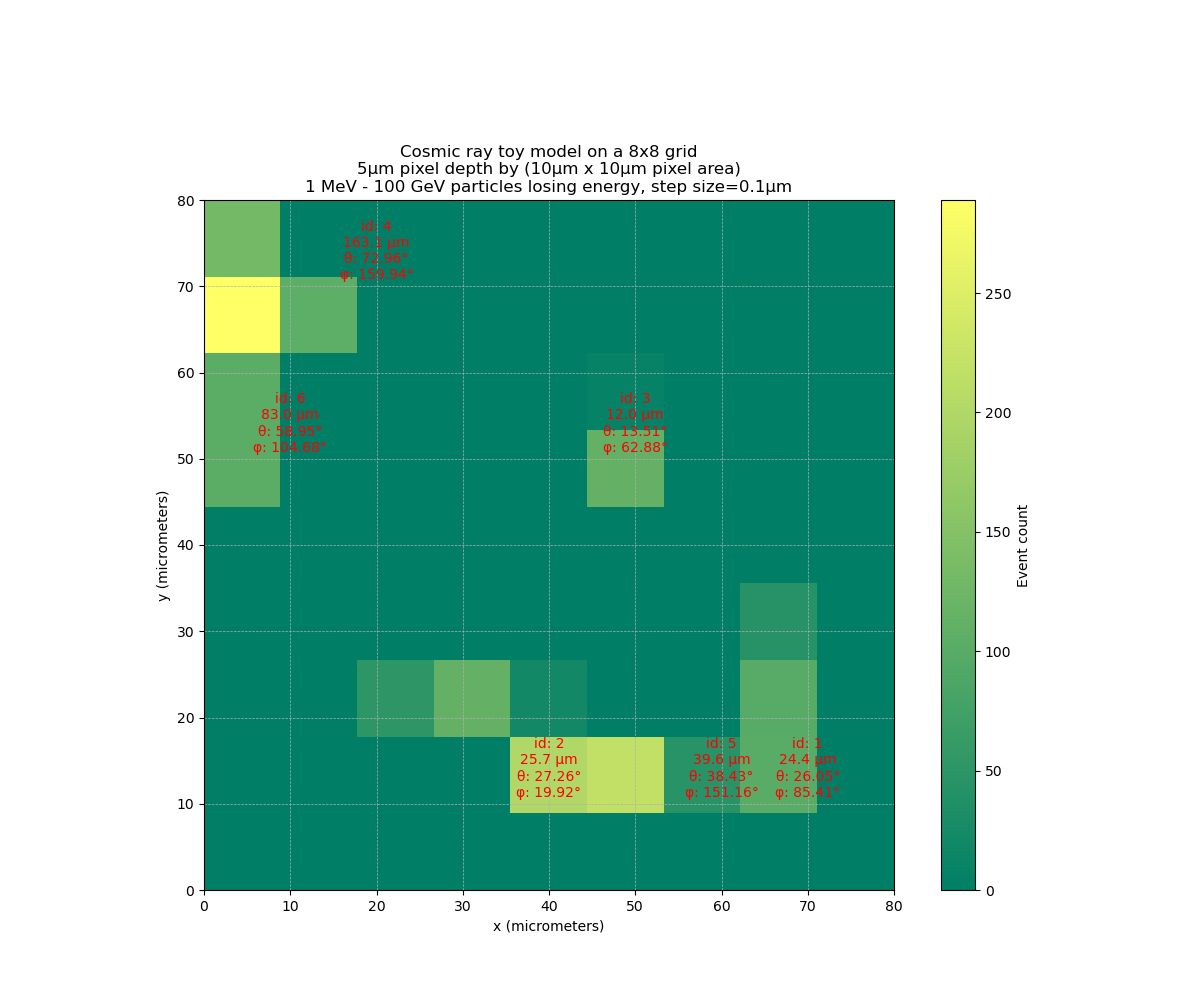

Sample 1: x=70 µm, y=10 µm, theta=26.05°, phi=85.41°, E_init=5.5e+04 MeV
Sample 2: x=40 µm, y=10 µm, theta=27.26°, phi=19.92°, E_init=3e+04 MeV
Sample 3: x=50 µm, y=50 µm, theta=13.51°, phi=62.88°, E_init=9.2e+04 MeV
Sample 4: x=20 µm, y=70 µm, theta=72.96°, phi=159.94°, E_init=8.5e+04 MeV
Sample 5: x=60 µm, y=10 µm, theta=38.43°, phi=151.16°, E_init=2e+04 MeV
Sample 6: x=10 µm, y=50 µm, theta=58.95°, phi=104.68°, E_init=6e+03 MeV
Average number of steps per CR is 579.6666666666666, or an average length of 57.96666666666667µm


In [3]:
# Function to generate theta, phi, initial energy, and velocity
def generate_angles(init_en):
    vel = np.sqrt((2 * init_en) / m[1])
    P = np.random.uniform(0, 1)
    theta = np.arcsin(np.sqrt(P))
    phi = np.random.uniform(0, 2 * np.pi)
    return theta, phi, vel

# Function to calculate beta
def beta(Ekin):
    total_energy = Ekin + M
    p = np.sqrt(total_energy**2 - M**2)
    return p / total_energy

# Function to calculate gamma
def gamma(Ekin):
    return (Ekin + M) / M

def compute_curvature(positions):
    """
    Computes the curvature (kappa) at each point along a particle's trajectory.

    Parameters:
    positions : list or array-like
        List of (x, y, z) tuples representing the particle's positions.

    Returns:
    kappa_values : numpy array
        Array of curvature values at each point along the trajectory.
    """
    positions = np.array(positions)
    n_points = positions.shape[0]

    if n_points < 3:
        # Need at least 3 points to compute curvature
        return np.array([0])      # NOTE: changed from ' np.array([]) ' to ' np.array([0]) '

    # Initialize array to hold curvature values
    kappa_values = np.zeros(n_points - 2)

    # Loop over the trajectory points
    for i in range(1, n_points - 1):
        # Get three consecutive points
        p0 = positions[i - 1]
        p1 = positions[i]
        p2 = positions[i + 1]

        # Vectors between the points
        vec1 = p1 - p0
        vec2 = p2 - p1

        # Calculate the norms of the vectors
        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)

        # Compute the unit tangent vectors
        if norm_vec1 == 0 or norm_vec2 == 0:
            # Avoid division by zero
            kappa_values[i - 1] = 0
            continue

        t1 = vec1 / norm_vec1
        t2 = vec2 / norm_vec2

        # Change in tangent vector
        delta_t = t2 - t1
        norm_delta_t = np.linalg.norm(delta_t)

        # Average arc length between points
        ds = (norm_vec1 + norm_vec2) / 2

        # Curvature calculation
        if ds == 0:
            kappa = 0
        else:
            kappa = norm_delta_t / ds

        kappa_values[i - 1] = kappa

    return kappa_values

def transform_angles(theta_p, phi_p, theta_d, phi_d):
    """
    Transforms delta ray emission angles from the particle's frame to the global frame.

    Parameters:
    theta_p, phi_p : float
        Primary particle's current direction angles in radians.
    theta_d, phi_d : float
        Delta ray's emission angles in the primary particle's frame in radians.

    Returns:
    theta_global, phi_global : float
        Delta ray's direction angles in the global coordinate system.
    """
    # Convert angles to direction vectors
    # Primary particle's direction vector
    vp = np.array([
        np.sin(theta_p) * np.cos(phi_p),
        np.sin(theta_p) * np.sin(phi_p),
        np.cos(theta_p)
    ])

    # Delta ray's direction vector in the particle's frame
    vd = np.array([
        np.sin(theta_d) * np.cos(phi_d),
        np.sin(theta_d) * np.sin(phi_d),
        np.cos(theta_d)
    ])

    # Build rotation matrix to align z-axis with vp
    # Calculate the axis-angle representation
    axis = np.cross([0, 0, 1], vp)
    if np.linalg.norm(axis) != 0:
        axis = axis / np.linalg.norm(axis)
        angle = np.arccos(np.dot([0, 0, 1], vp))
        # Build rotation matrix using Rodrigues' rotation formula
        K = np.array([
            [0, -axis[2], axis[1]],
            [axis[2], 0, -axis[0]],
            [-axis[1], axis[0], 0]
        ])
        R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.dot(K, K)
    else:
        R = np.eye(3)

    # Transform vd to global coordinate system
    vd_global = np.dot(R, vd)

    # Convert direction vector to angles
    theta_global = np.arccos(vd_global[2])
    phi_global = np.arctan2(vd_global[1], vd_global[0])

    return theta_global, phi_global


# Function to apply streaks with user-defined step sizes and energy loss
def apply_streak(heatmap, x, y, theta, phi, init_en, vel, SID, streaks):
    L = cell_depth * np.tan(theta)
    num_steps = int(L * cell_size / step_size)
    current_energy = init_en
    
    for i in range(num_steps):
        if current_energy <= 0:
            current_energy = 0
            break        
        dx_um = i * step_size * np.cos(phi)
        dy_um = i * step_size * np.sin(phi)
        new_x = x * cell_size + dx_um
        new_y = y * cell_size + dy_um
        grid_x = int(new_x / cell_size)
        grid_y = int(new_y / cell_size)
        if 0 <= grid_x <= grid_size and 0 <= grid_y <= grid_size:
            heatmap[grid_y, grid_x] += 1
            if i == 0:  # Only annotate the first point of the streak
                streaks.append((new_x, new_y, SID, num_steps, theta, phi))
        dE = bb_eqn(vel)
        current_energy -= dE
        if current_energy <= 0:
            current_energy = 0
            break
        vel = np.sqrt((2 * current_energy) / m[1])

# Generate points and angles
points = []
heatmap = np.zeros((grid_size + 1, grid_size + 1), dtype=int)
streaks = []

# Wrap the loop with tqdm for progress bar
for SID in tqdm(range(1, poisson_samples.sum() +1 ), desc="Processing events"):
    x = np.random.randint(0, grid_size + 1)
    y = np.random.randint(0, grid_size + 1)
    init_en = np.random.uniform(E_min, E_max)
    theta, phi, vel = generate_angles(init_en)
    points.append((x, y, theta, phi, init_en, vel))
    apply_streak(heatmap, x, y, theta, phi, init_en, vel, SID, streaks)

# Convert grid points to physical coordinates in micrometers
physical_points = [(x * cell_size, y * cell_size, theta, phi, init_en, vel) for x, y, theta, phi, init_en, vel in points]

# Plot the heatmap with physical dimensions
plt.figure(figsize=(12, 10))
plt.imshow(heatmap, cmap='summer', interpolation='nearest', origin='lower', extent=[0, grid_size * cell_size, 0, grid_size * cell_size])
plt.colorbar(label='Event count')
plt.title(f'Cosmic ray toy model on a {grid_size}x{grid_size} grid\n{cell_depth}µm pixel depth by ({cell_size}µm x {cell_size}µm pixel area)\n1 MeV - 100 GeV particles losing energy, step size={step_size}µm')
plt.subplots_adjust(top=0.8)
plt.xlabel('x (micrometers)')
plt.ylabel('y (micrometers)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate the streaks
for (new_x, new_y, SID, num_steps, theta, phi) in streaks:
    plt.annotate(f"id: {SID}\n{num_steps * step_size:.1f} µm\nθ: {theta*180/np.pi:.2f}°\nφ: {phi*180/np.pi:.2f}°", 
                 (new_x, new_y), textcoords="offset points", xytext=(0, 5), ha='center', color='red')

plt.show()

# Display some streak IDs
for i, (x, y, theta, phi, init_en, vel) in enumerate(physical_points[:len(streaks) // 1]):
    print(f"Sample {i+1}: x={x} µm, y={y} µm, theta={(theta / (2 * np.pi)) * 360:.2f}°, phi={(phi / (2 * np.pi)) * 360:.2f}°, E_init={init_en:.2g} MeV")

total_steps = sum(streak[3] for streak in streaks)
print(f"Average number of steps per CR is {total_steps / len(streaks)}, or an average length of {(total_steps / len(streaks)) * step_size}µm")


In [4]:
#add code to convert legend from event count to pixels affected

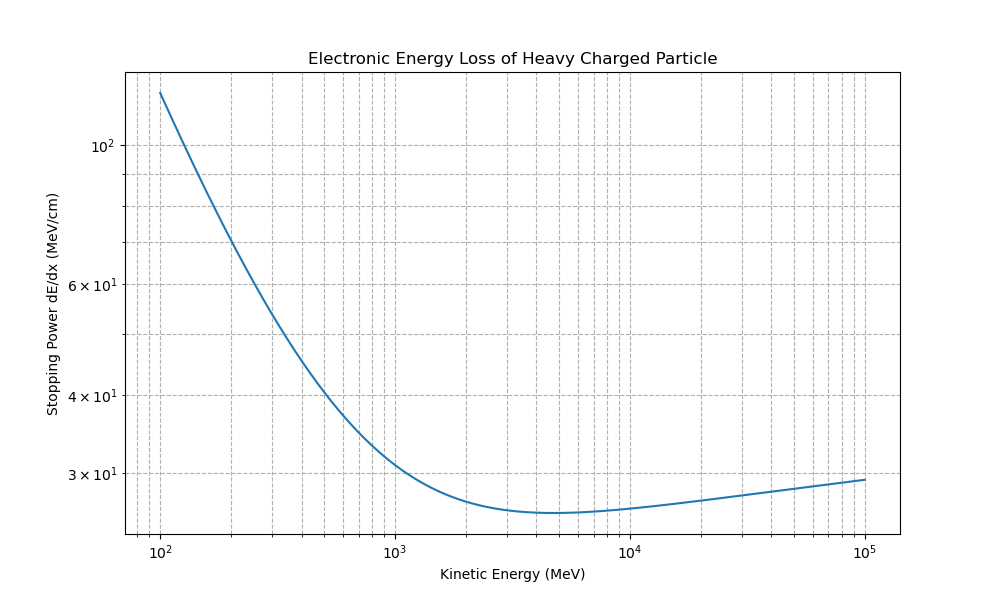

In [5]:
# Energy range (100 MeV to 100 GeV)
Ekin = np.logspace(2, 5, 1000)  # Kinetic energy in MeV

# Function to calculate Tmax
def Tmax(Ekin):
    beta_val = beta(Ekin)
    gamma_val = gamma(Ekin)
    return (2 * me * beta_val**2 * gamma_val**2) / (1 + 2 * gamma_val * me / M + (me / M)**2)

# Function to calculate dE/dx
def dEdx(Ekin):
    beta_val = beta(Ekin)
    gamma_val = gamma(Ekin)
    tmax = Tmax(Ekin)
    prefactor = (K * Z_material * Z_particle**2) / (A_material * beta_val**2)
    argument = (2 * me * c**2 * beta_val**2 * gamma_val**2 * tmax) / (I**2)
    delta = 0  # Density correction (neglected for simplicity)
    shell = 0  # Shell correction (neglected for simplicity)
    return prefactor * (np.log(argument) - 2 * beta_val**2 - delta - shell) * density

# Calculate dE/dx over the energy range
stopping_power = dEdx(Ekin)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.loglog(Ekin, stopping_power)
plt.title('Electronic Energy Loss of Heavy Charged Particle')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Stopping Power dE/dx (MeV/cm)')
plt.grid(True, which='both', ls='--')
plt.show()


In [6]:
delta_ray_counter = itertools.count(1)

# functions

def apply_delta_ray(heatmap, x, y, theta, phi, init_en, SID, streaks):
    s = step_size  # Step size in micrometers (µm)
    x0 = x * cell_size  # Initial x position in µm
    y0 = y * cell_size  # Initial y position in µm
    z0 = 0  # Initial z position in µm

    current_energy = init_en  # Kinetic energy in MeV

    positions = []  # List to store positions (x, y, z)

    # Constants for electrons
    me = 0.5109989461  # Electron mass (MeV/c^2)
    c = 2.99792458e10  # Speed of light (cm/s)

    # Material properties (Example: Silicon)
    Z_material = 14  # Atomic number of material
    A_material = 28.0855  # Atomic mass of material (g/mol)
    I = 173e-6  # Mean excitation potential (MeV)
    density = 2.3290  # Density of material (g/cm^3)
    
    # Particle properties
    Z_particle = 1  # Charge number of the particle
    M = 938.27208816  # Mass of the particle (MeV/c^2), example for proton

    # Convert step size from µm to cm
    s_cm = s * 1e-4  # s in cm

    # Radiation length X0 for the material (in cm)
    # For Silicon, X0 ≈ 9.36 g/cm^2
    # Need to convert to cm by dividing by density
    X0 = 21.82  # Radiation length for Silicon in cm
    
    # Stopping power for electrons (from Section 33.4 of PDG)
    def dEdx_electron(E):
        # Compute stopping power for electrons
        # This can be complex; for simplicity, use a function or empirical data
        # Placeholder using the Bethe formula for electrons:
        beta_val = np.sqrt(1 - (me / (E + me)) ** 2)
        gamma_val = (E + me) / me
        W_max = E  # Maximum energy transfer in electron-electron collision is the total kinetic energy
        I = 173e-6  # Mean excitation potential (MeV)
        delta = 0  # Density effect correction
        return (K * Z_material) / (A_material * beta_val ** 2) * (0.5 * np.log(2 * me * beta_val ** 2 * gamma_val ** 2 * W_max / I ** 2) - beta_val ** 2 - delta) * density  # MeV/cm

    while current_energy > 0:
        # Calculate positions
        delta_x = s * np.sin(theta) * np.cos(phi)
        delta_y = s * np.sin(theta) * np.sin(phi)
        delta_z = s * np.cos(theta)

        x0 += delta_x
        y0 += delta_y
        z0 += delta_z

        # Check if the electron is still within the volume
        if not (0 <= x0 <= cell_size * grid_size and 0 <= y0 <= cell_size * grid_size and 0 <= z0 <= cell_depth):
            break  # Electron has exited the physical volume

        grid_x = int(x0 / cell_size)
        grid_y = int(y0 / cell_size)
        if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
            heatmap[grid_y, grid_x] += 1
            positions.append((x0, y0, z0))
        else:
            # Electron has exited the grid (should not happen if physical volume matches grid)
            break

        # Energy loss per step
        dE_dx = dEdx_electron(current_energy)
        dE = dE_dx * s_cm
        current_energy -= np.abs(dE)

        if current_energy <= 0:
            current_energy = 0
            break

        # Update direction due to multiple scattering
        # Calculate beta and momentum p
        beta_val1 = np.sqrt(1 - (me / (current_energy + me)) ** 2)
        p = beta_val1 * (current_energy + me) / c  # Momentum in MeV/c

        # Calculate RMS scattering angle theta0
        # Highland's formula (theta0 in radians)
        theta0_values = []
        theta0 = (13.6 / (beta_val1 * current_energy)) * np.sqrt(s_cm / X0) * (1 + 0.038 * np.log(s_cm / X0))
        theta0_values.append(theta0)
        
        # Sample scattering angles from Gaussian distribution
        delta_theta = np.random.normal(0, theta0)
        delta_phi = np.random.uniform(0, 2 * np.pi)

        # Update the direction angles
        # Convert current theta and phi to direction vector
        vx = np.sin(theta) * np.cos(phi)
        vy = np.sin(theta) * np.sin(phi)
        vz = np.cos(theta)

        # Generate small changes in direction due to scattering
        # Use spherical coordinates to update the direction
        # Rotate the direction vector by delta_theta and delta_phi
        # For small angles, the following approximations can be used
        vx_new = vx + delta_theta * np.cos(delta_phi)
        vy_new = vy + delta_theta * np.sin(delta_phi)
        vz_new = vz  # Assuming small-angle approximation

        # Normalize the new direction vector
        norm = np.sqrt(vx_new**2 + vy_new**2 + vz_new**2)
        vx_new /= norm
        vy_new /= norm
        vz_new /= norm

        # Update theta and phi based on new direction vector
        theta_init = theta
        phi_init = phi
        theta = np.arccos(vz_new)
        phi = np.arctan2(vy_new, vx_new)

    # After the loop, if positions were recorded, append the streak data
    if positions:
        start_pos = positions[0]
        end_pos = positions[-1]
        streaks.append((positions, SID, len(positions), theta_init, phi_init, theta, phi, theta0_values, x0, y0, z0, start_pos, end_pos, init_en, current_energy))


def apply_streak(heatmap, x, y, theta, phi, init_en, SID, streaks):
    s = step_size  # Step size in micrometers (µm)
    x0 = x * cell_size  # Initial x position in µm
    y0 = y * cell_size  # Initial y position in µm
    z0 = 0  # Initial z position in µm

    # Total path length in the medium
    L = cell_depth / np.cos(theta)  # Path length in µm
    num_steps = int(L / s)

    current_energy = init_en  # Kinetic energy in MeV

    positions = []  # List to store positions (x, y, z)
    theta0_values = []
    theta_init = theta
    phi_init = phi
    
    # Constants for electrons
    me = 0.5109989461  # Electron mass (MeV/c^2)
    c = 2.99792458e10  # Speed of light (cm/s)

    # Material properties (Example: Silicon)
    Z_material = 14  # Atomic number of material
    A_material = 28.0855  # Atomic mass of material (g/mol)
    I = 173e-6  # Mean excitation potential (MeV)
    density = 2.3290  # Density of material (g/cm^3)
    
    # Particle properties
    Z_particle = 1  # Charge number of the particle
    M = 938.27208816  # Mass of the particle (MeV/c^2), example for proton

    # Convert step size from µm to cm
    s_cm = s * 1e-4  # s in cm
    
    # Function to calculate differential cross-section for delta ray production
    def dN_dT(T, Ekin):
        beta_val = beta(Ekin)
        prefactor = (K * Z_material * Z_particle ** 2) / (A_material * beta_val ** 2)
        return prefactor * (1 / T ** 2)  # Simplified formula

    # Minimum energy for delta rays to be considered (e.g., 1 keV)
    T_min = 0.001  # MeV
    # Maximum energy transferable
    def Tmax(Ekin):
        beta_val = beta(Ekin)
        gamma_val = gamma(Ekin)
        return (2 * me * beta_val ** 2 * gamma_val ** 2) / (
            1 + 2 * gamma_val * me / M + (me / M) ** 2
        )

    ### Main Loop ###
    i = 0  # Initialize step counter
    while current_energy > 0:
        # Calculate positions
        delta_x = s * np.sin(theta) * np.cos(phi)
        delta_y = s * np.sin(theta) * np.sin(phi)
        delta_z = s * np.cos(theta)

        x0 += delta_x
        y0 += delta_y
        z0 += delta_z

        # Check if the particle is still within the volume
        if not (0 <= x0 <= cell_size * grid_size and 0 <= y0 <= cell_size * grid_size and 0 <= z0 <= cell_depth):
            break  # Particle has exited the physical volume

        grid_x = int(x0 / cell_size)
        grid_y = int(y0 / cell_size)
        if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
            heatmap[grid_y, grid_x] += 1
            positions.append((x0, y0, z0))
        else:
            # Particle has exited the grid (should not happen if physical volume matches grid)
            break

        # Energy loss per step
        dE_dx = dEdx(current_energy)  # MeV/cm
        dE = dE_dx * s_cm  # Energy loss over step size s_cm in MeV

        # Determine if a delta ray is produced
        T_max = Tmax(current_energy)
        delta_N = dN_dT(T_min, current_energy) * (T_max - T_min) * s_cm  # Expected number of delta rays in this step

        # Decide probabilistically whether to produce a delta ray
        prob_delta_ray = delta_N
        if np.random.uniform(0, 1) < prob_delta_ray:
            # Produce a delta ray
            T_delta = np.random.uniform(T_min, T_max)

            # Subtract the energy transferred to the delta ray from the current energy
            current_energy -= T_delta
            if current_energy <= 0:
                current_energy = 0
                break

            # Delta ray emission angles (relative to primary particle's current direction)
            theta_delta = np.arccos(1 - 2 * np.random.uniform(0, 1))
            phi_delta = 2 * np.pi * np.random.uniform(0, 1)

            # Adjust delta ray angles to be relative to the global coordinate system
            # Transform delta ray angles from the particle's frame to the global frame
            theta_global, phi_global = transform_angles(theta, phi, theta_delta, phi_delta)

            # Start position is the current position
            x_delta = x0
            y_delta = y0
            z_delta = z0

            # Recursively apply apply_delta_ray to the delta ray
            delta_ray_id = next(delta_ray_counter)
            apply_delta_ray(heatmap, x_delta / cell_size, y_delta / cell_size, theta_global, phi_global, T_delta, SID * 2000 + delta_ray_id, streaks)

        current_energy -= dE
        if current_energy <= 0:
            current_energy = 0
            break

        # Update direction due to multiple scattering
        # Calculate beta and momentum p
        mp = M
        beta_val2 = np.sqrt(1 - (mp / (current_energy + mp)) ** 2)
        p = beta_val2 * (current_energy + mp) / c  # Momentum in MeV/c
        
        X0 = 21.82  # Radiation length for Silicon in cm
        
        # Calculate RMS scattering angle theta0
        # Highland's formula (theta0 in radians)
        theta0 = (13.6 / (beta_val2 * p * c)) * np.sqrt(s_cm / X0) * (1 + 0.038 * np.log(s_cm / X0))
        theta0_values.append(theta0)
        
        # Sample scattering angles from Gaussian distribution
        delta_theta = np.random.normal(0, theta0)
        delta_phi = np.random.uniform(0, 2 * np.pi)

        # Update the direction angles
        # Convert current theta and phi to direction vector
        vx = np.sin(theta) * np.cos(phi)
        vy = np.sin(theta) * np.sin(phi)
        vz = np.cos(theta)

        # Generate small changes in direction due to scattering
        # Rotate the direction vector by delta_theta and delta_phi
        # Use rotation matrices or vector addition for more accuracy
        # For small angles, approximations can be used
        vx_new = vx + delta_theta * np.cos(delta_phi)
        vy_new = vy + delta_theta * np.sin(delta_phi)
        vz_new = vz  # Assuming small-angle approximation

        # Normalize the new direction vector
        norm = np.sqrt(vx_new**2 + vy_new**2 + vz_new**2)
        vx_new /= norm
        vy_new /= norm
        vz_new /= norm

        # Update theta and phi based on new direction vector
        theta = np.arccos(vz_new)
        phi = np.arctan2(vy_new, vx_new)

        i += 1  # Increment step counter

    # After the loop, if positions were recorded, append the streak data
    if positions:
        start_pos = positions[0]
        end_pos = positions[-1]
        streaks.append((positions, SID, len(positions), theta_init, phi_init, theta, phi, theta0_values, x0, y0, z0, start_pos, end_pos, init_en, current_energy))


# Define function to get color based on SID
def get_particle_color(SID):
    global SID_ranges
    global color_list
    if SID < 1000:
        return 'black'  # Color for primary particles
    elif SID >= SID_ranges[0][0] and SID < SID_ranges[0][1]:
        return color_list[0][1]
    elif SID >= SID_ranges[1][0] and SID < SID_ranges[1][1]:
        return color_list[1][1]
    elif SID >= SID_ranges[2][0] and SID < SID_ranges[2][1]:
        return color_list[2][1]
    elif SID >= SID_ranges[3][0] and SID < SID_ranges[3][1]:
        return color_list[3][1]
    elif SID >= SID_ranges[4][0] and SID < SID_ranges[4][1]:
        return color_list[4][1]
    elif SID > SID_ranges[5][0] and SID < SID_ranges[5][1]:
        return color_list[5][1]
    elif SID >= SID_ranges[6][0] and SID < SID_ranges[6][1]:
        return color_list[6][1]
    elif SID >= SID_ranges[7][0] and SID < SID_ranges[7][1]:
        return color_list[7][1]
    elif SID >= SID_ranges[8][0] and SID < SID_ranges[8][1]:
        return color_list[8][1]
    elif SID >= SID_ranges[9][0] and SID < SID_ranges[9][1]:
        return color_list[9][1]
    elif SID >= SID_ranges[10][0] and SID < SID_ranges[10][1]:
        return color_list[10][1]
    elif SID >= SID_ranges[11][0] and SID < SID_ranges[11][1]:
        return color_list[11][1]
    elif SID >= SID_ranges[12][0] and SID < SID_ranges[12][1]:
        return color_list[12][1]
    elif SID > SID_ranges[13][0] and SID < SID_ranges[13][1]:
        return color_list[13][1]
    elif SID >= SID_ranges[14][0] and SID < SID_ranges[14][1]:
        return color_list[14][1]
    elif SID >= SID_ranges[15][0] and SID < SID_ranges[15][1]:
        return color_list[15][1]
    elif SID >= SID_ranges[16][0] and SID < SID_ranges[16][1]:
        return color_list[16][1]
    elif SID >= SID_ranges[17][0] and SID < SID_ranges[17][1]:
        return color_list[17][1]
    elif SID > SID_ranges[18][0] and SID < SID_ranges[18][1]:
        return color_list[18][1]
    elif SID >= SID_ranges[19][0] and SID < SID_ranges[19][1]:
        return color_list[19][1]
    elif SID >= SID_ranges[20][0] and SID < SID_ranges[20][1]:
        return color_list[20][1]
    elif SID >= SID_ranges[21][0] and SID < SID_ranges[21][1]:
            return color_list[21][1]
    elif SID >= SID_ranges[22][0] and SID < SID_ranges[22][1]:
            return color_list[22][1]
    elif SID >= SID_ranges[23][0] and SID < SID_ranges[23][1]:
            return color_list[23][1]
    else:
        return color_list[24][1]

# Function that sets alpha (transperacy) based on change in total energy
def get_alpha(SID, init_en, current_energy):
    val = np.abs(current_energy - init_en) /  np.abs(init_en)
    if SID < 10:
        return 1
    elif SID == 1000 or SID == 1001:
        return 1
    elif init_en > 0.25:
        return 0.1
    elif val <= 0:
        return 0.01
    elif val >= 0:
        return 1
    else:
        return val



In [7]:
CR_target_number = 30

particle_totals = []

# Simulation parameters
lambda_value = 1  # expected number of hits per event
grid_size = 4088  # Number of pixels along x & y
cell_size = 10  # Size of each pixel in micrometers (analogous to pixel pitch)
cell_depth = 5  # Depth of each pixel in micrometers (analogous to pixel thickness)
step_size = 0.1  # Step size in micrometers
num_samples = CR_target_number  # Number of events (can potentially use samples as a proxy for total dt, t_exp)

# Sampling from Poisson distribution
poisson_samples = np.random.poisson(lambda_value, num_samples)
while poisson_samples.sum() < CR_target_number:
    poisson_samples = np.random.poisson(lambda_value, num_samples)


# Generate points and angles
points = []
heatmap = np.zeros((grid_size + 1, grid_size + 1), dtype=int)
streaks = []
counter = 0
# Wrap the loop with tqdm for progress bar
for SID in tqdm(range(1, poisson_samples.sum() +1 ), desc="Processing events"):
    x = np.random.randint(0, grid_size + 1)
    y = np.random.randint(0, grid_size + 1)
    init_en = np.random.uniform(E_min, E_max)
    theta, phi, vel = generate_angles(init_en)
    points.append((x, y, theta, phi, init_en, vel))
    apply_streak(heatmap, x, y, theta, phi, init_en, SID, streaks)
    if counter == 0:
        particle_totals.append(len(streaks))
    else:
        prev_values = np.sum(particle_totals)
        particle_totals.append(len(streaks)-prev_values)
    delta_ray_counter = itertools.count(1)
    counter += 1


Processing events: 100%|██████████| 36/36 [02:03<00:00,  3.44s/it]


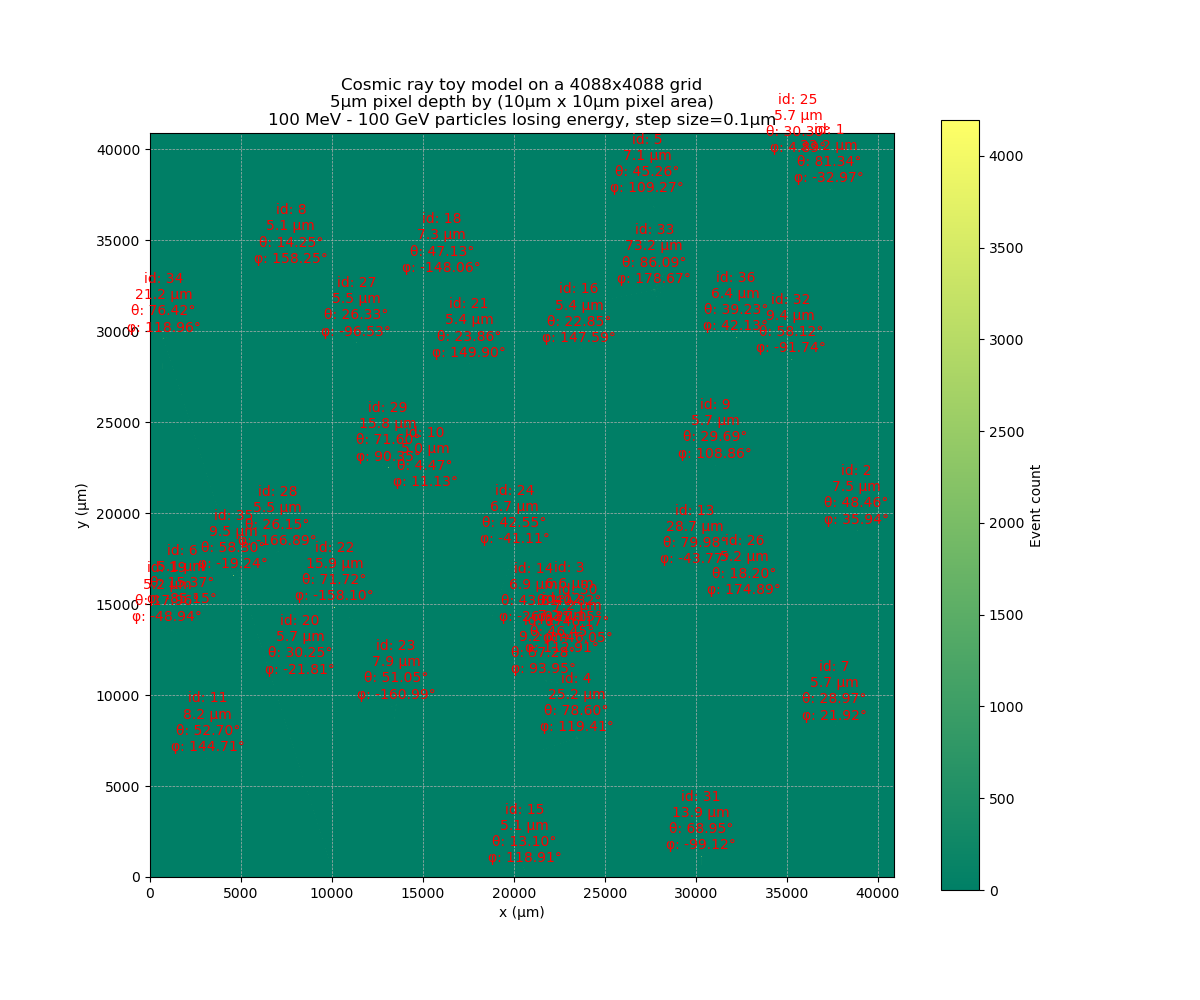

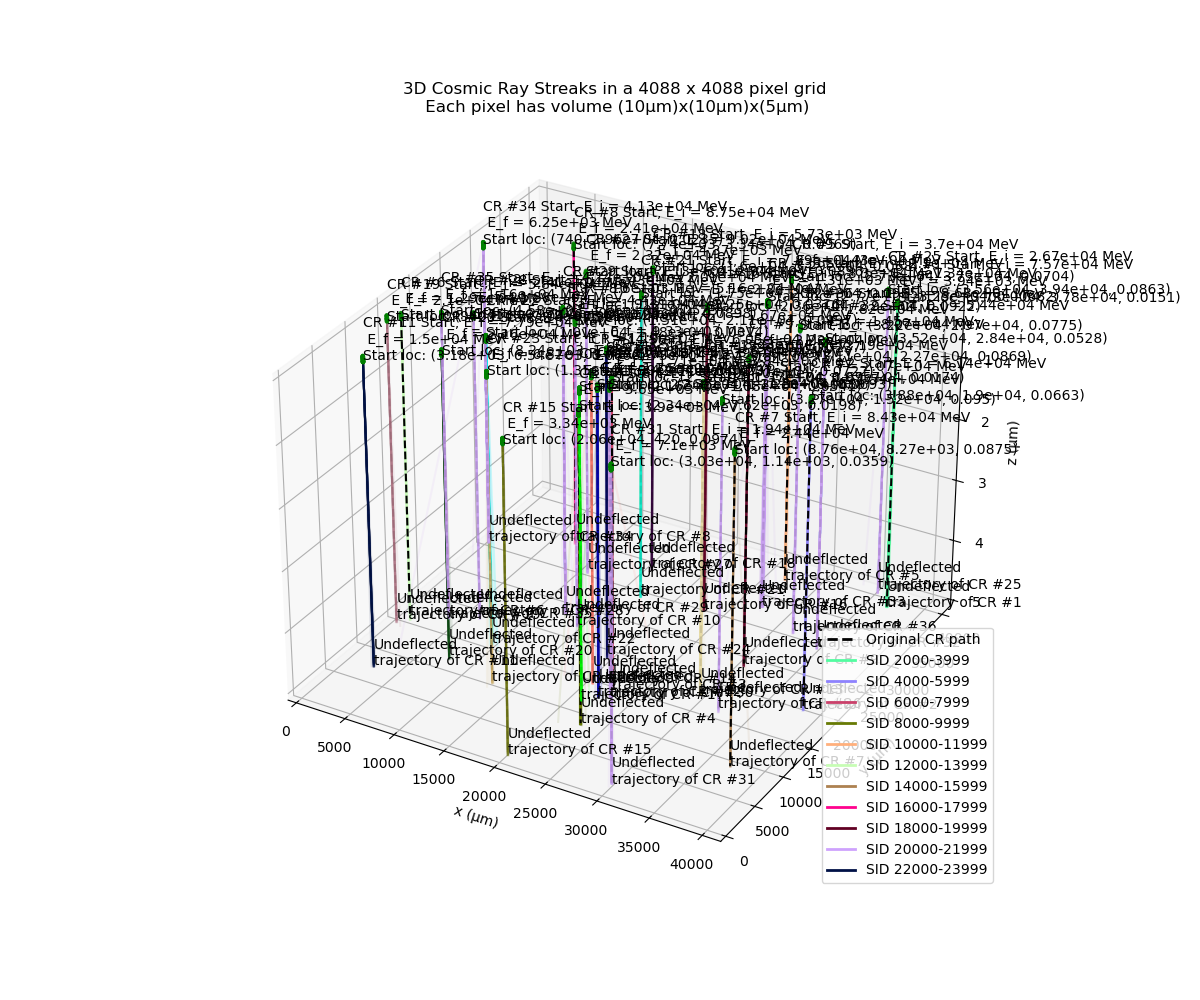

In [9]:
plt.close('all')

# Plot the heatmap (2D)
plt.figure(figsize=(12, 10))
plt.imshow(heatmap, cmap='summer', interpolation='nearest', origin='lower',
           extent=[0, grid_size * cell_size, 0, grid_size * cell_size])
plt.colorbar(label='Event count')
plt.title(f'Cosmic ray toy model on a {grid_size}x{grid_size} grid\n'
          f'{cell_depth}µm pixel depth by ({cell_size}µm x {cell_size}µm pixel area)\n'
          f'100 MeV - 100 GeV particles losing energy, step size={step_size}µm')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate the streaks
for (positions, SID, num_steps, theta_init, phi_init, theta, phi, theta0_values, x0, y0, z0, start_pos, end_pos, init_en, current_energy) in streaks:
    new_x, new_y, new_z = positions[0]
    if SID < 1000:
        plt.annotate(f"id: {SID}\n{num_steps * step_size:.1f} µm\nθ: {theta * 180 / np.pi:.2f}°\nφ: {phi * 180 / np.pi:.2f}°",
                 (new_x, new_y), textcoords="offset points", xytext=(0, 5), ha='center', color='red')

plt.show()

# Create a 3D plot of the streaks

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the streaks
for (positions, SID, num_steps, theta_init, phi_init, theta, phi, theta0_values, x0, y0, z0, start_pos, end_pos, init_en, current_energy) in streaks:
    val = np.abs(current_energy - init_en) /  np.abs(init_en)
    xs, ys, zs = zip(*positions)
    color = get_particle_color(SID)
    alpha = get_alpha(SID, init_en, current_energy)
    if SID < 1000:  
        ax.plot(xs, ys, zs, label=f'SID {SID}', color = color, alpha = alpha, ls = '--')
    else:    
        ax.plot(xs, ys, zs, label=f'SID {SID}', color = color, alpha = alpha )

    kappa_values = compute_curvature(positions)
    
    # Annotate the starting point
    if SID < 1000:
        ax.text(xs[0], ys[0], zs[0],
            f'CR #{SID} Start, E_i = {init_en:.3g} MeV\n E_f = {current_energy:.3g} MeV\nStart loc: ({start_pos[0]:.3g}, {start_pos[1]:.3g}, {start_pos[2]:.3g})',
            color='black')
    # Annotate the ending point   
    if SID < 1000:
        ax.text(xs[-1], ys[-1], zs[-1],
            f'Undeflected\ntrajectory of CR #{SID}',
            color='black')
    elif SID > 1000 and max(kappa_values) > 20:
        ax.text(xs[-1], ys[-1], zs[-1],
            f'E_i = {init_en:.3g} MeV\nE_f = {current_energy:.3g} MeV\nSID = {SID}',
            color='fuchsia', alpha = 0.5)


# Lists to hold starting points of delta electrons
delta_start_and_end_x = []
delta_start_and_end_y = []
delta_start_and_end_z = []

# Define colors
delta_start_color = 'green'  # Color for delta electron starting points

# Prepare the data
for (positions, SID, num_steps, theta_init, phi_init, theta, phi, theta0_values, x0, y0, z0, start_pos, end_pos, init_en, current_energy) in streaks:
    SID = SID
    
    # Create a list of (x, y, z) coordinates
    #coords = np.column_stack((x_vals, y_vals, z_vals))
    
    if SID > 1000: # secondary particles only
        # Extract starting point of the delta electron
        start_x = positions[0][0]
        end_x = positions[-1][0]
        start_y = positions[0][1]
        end_y = positions[-1][1]
        start_z = positions[0][2]
        end_z = positions[-1][2]
        delta_start_and_end_x.append([start_x,end_x])
        delta_start_and_end_y.append([start_y,end_y])
        delta_start_and_end_z.append([start_z,end_z])

start_pts_x = [sublist[0] for sublist in delta_start_and_end_x]
start_pts_y = [sublist[0] for sublist in delta_start_and_end_y]
start_pts_z = [sublist[0] for sublist in delta_start_and_end_z]

end_pts_x = [sublist[1] for sublist in delta_start_and_end_x]
end_pts_y = [sublist[1] for sublist in delta_start_and_end_y]
end_pts_z = [sublist[1] for sublist in delta_start_and_end_z]

# Plot the starting points of delta electrons
ax.scatter(start_pts_x, start_pts_y, start_pts_z, color=delta_start_color, marker='o', s=5, label='Delta Electron Start')

# Set labels and title
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('z (µm)')
ax.set_title(f'3D Cosmic Ray Streaks in a {grid_size} x {grid_size} pixel grid\n Each pixel has volume ({cell_size}µm)x({cell_size}µm)x({cell_depth}µm)')

# Reverse the z-axis so that z=0 is at the top
ax.set_zlim(cell_depth, 0)  # Flip the z-axis
ax.set_zticks(np.linspace(cell_depth, 0, 6))
ax.set_zticklabels([f'{int(tick)}' for tick in np.linspace(cell_depth, 0, 6)])

# Set x and y axis limits
ax.set_xlim(0, grid_size * cell_size)
ax.set_ylim(0, grid_size * cell_size)

legend_markers = [Line2D([0], [0], color = 'black', lw = 2, ls = '--'), Line2D([0], [0], color = color_list[0][1], lw = 2), Line2D([0], [0], color = color_list[1][1], lw = 2), Line2D([0], [0], color = color_list[2][1], lw = 2), Line2D([0], [0], color = color_list[3][1], lw = 2), Line2D([0], [0], color = color_list[4][1], lw = 2), Line2D([0], [0], color = color_list[5][1], lw = 2), Line2D([0], [0], color = color_list[6][1], lw = 2), Line2D([0], [0], color = color_list[7][1], lw = 2), Line2D([0], [0], color = color_list[8][1], lw = 2), Line2D([0], [0], color = color_list[9][1], lw = 2), Line2D([0], [0], color = color_list[10][1], lw = 2)]

ax.legend(legend_markers,['Original CR path', f'SID {SID_ranges[0][0]}-{SID_ranges[0][1]}', f'SID {SID_ranges[1][0]}-{SID_ranges[1][1]}', f'SID {SID_ranges[2][0]}-{SID_ranges[2][1]}', f'SID {SID_ranges[3][0]}-{SID_ranges[3][1]}', f'SID {SID_ranges[4][0]}-{SID_ranges[4][1]}', f'SID {SID_ranges[5][0]}-{SID_ranges[5][1]}', f'SID {SID_ranges[6][0]}-{SID_ranges[6][1]}', f'SID {SID_ranges[7][0]}-{SID_ranges[7][1]}', f'SID {SID_ranges[8][0]}-{SID_ranges[8][1]}', f'SID {SID_ranges[9][0]}-{SID_ranges[9][1]}', f'SID {SID_ranges[10][0]}-{SID_ranges[10][1]}', f'SID {SID_ranges[11][0]}-{SID_ranges[11][1]}', f'SID {SID_ranges[12][0]}-{SID_ranges[12][1]}', f'SID {SID_ranges[13][0]}-{SID_ranges[13][1]}', f'SID {SID_ranges[14][0]}-{SID_ranges[14][1]}', f'SID {SID_ranges[15][0]}-{SID_ranges[15][1]}', f'SID {SID_ranges[16][0]}-{SID_ranges[16][1]}', f'SID {SID_ranges[17][0]}-{SID_ranges[17][1]}', f'SID {SID_ranges[18][0]}-{SID_ranges[18][1]}', f'SID {SID_ranges[19][0]}-{SID_ranges[19][1]}', f'SID {SID_ranges[20][0]}-{SID_ranges[20][1]}', f'SID {SID_ranges[21][0]}-{SID_ranges[21][1]}', f'SID {SID_ranges[22][0]}-{SID_ranges[22][1]}', f'SID {SID_ranges[23][0]}-{SID_ranges[23][1]}', 'SID > 5000'])
plt.show()

In [ ]:
plt.close('all')

[163, 33, 31, 130, 46, 28, 25, 29, 28, 29, 42, 42, 126, 36, 27, 32, 53, 34, 25, 29, 37, 80, 37, 33, 35, 26, 32, 24, 84, 39, 64, 47, 384, 107, 43, 34]
 The total number of particles was = 2094
The mean number of delta electrons per CR is 58.17 with st.dev 64.14


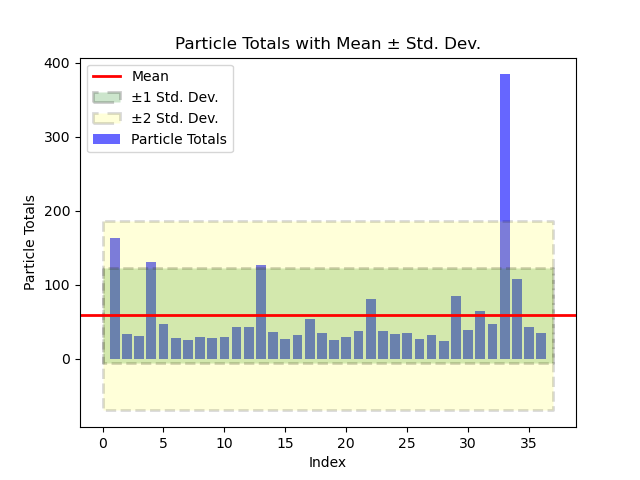

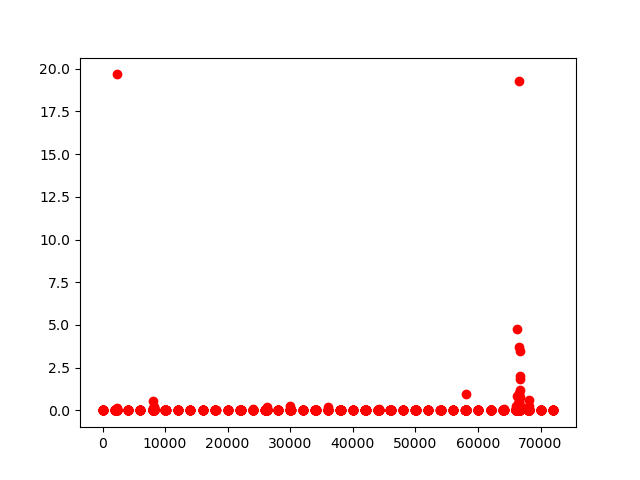

In [10]:
print(particle_totals)
print(f' The total number of particles was = {np.sum(particle_totals)}')

# Print mean and standard deviation
mean_particles = np.mean(particle_totals)
std_particles = np.std(particle_totals)
print(f'The mean number of delta electrons per CR is {mean_particles:.2f} with st.dev {std_particles:.2f}')

# Create a bar plot with a constant function representing the mean ± st.dev
x_positions = np.arange(1, len(particle_totals) + 1)  # X-axis: positions (1 to len(particle_totals))

fig, ax2 = plt.subplots()

# Bar plot
ax2.bar(x_positions, particle_totals, color='blue', alpha=0.6, label='Particle Totals')

# Plot the mean as a horizontal line
ax2.axhline(mean_particles, color='r', linestyle='-', linewidth=2, label='Mean')

# Shade the region for ±1 and ±2 standard deviation
ax2.fill_between(
    range(0,len(particle_totals) + 2),
    mean_particles - std_particles,
    mean_particles + std_particles,
    color='g', linestyle='--', linewidth=2,
    alpha=0.2, edgecolor = 'black',
    label='±1 Std. Dev.'
)

ax2.fill_between(
    range(0,len(particle_totals) + 2),
    mean_particles - 2*std_particles,
    mean_particles + 2*std_particles,
    color='yellow', linestyle='--', linewidth=2,
    alpha=0.15, edgecolor = 'black',
    label='±2 Std. Dev.'
)

# Add labels and legend
ax2.set_xlabel('Index')
ax2.set_ylabel('Particle Totals')
ax2.set_title('Particle Totals with Mean ± Std. Dev.')
ax2.legend()

# Show plot
plt.show()


max_kappa_vals = []
max_kappa_ids = []

for i in range(len(streaks)):
    max_kappa_vals.append(  max(compute_curvature(streaks[i][0])) )
    max_kappa_ids.append( streaks[i][1] )

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(max_kappa_ids, max_kappa_vals, marker='o',  c = 'r')

#plt.legend(loc = 'upper left')
plt.show()


In [11]:
top_n = 20 # chooses the n top curviest trajectories, starting from 0 being the curviest
index_num = 0 # indicates initial trajectory to look at

def plot_trajectory(index_num):
    """
    Plots the 3D trajectory for the given index_num.
    """

    # Clear all existing figures
    plt.close('all')

    # Prepare list of (id, kappa_val, i) for all kappas
    all_kappas = []
    for i in range(len(max_kappa_ids)):
        all_kappas.append([max_kappa_ids[i], max_kappa_vals[i], i])
    
    # Find the n "curviest" particles based on kappa_val
    curviest_part_traj = heapq.nlargest(top_n, all_kappas, key=lambda x: x[1])

    # Choose which trajectory to look at
    # index_num must be between 0 and n-1 (for the top n)
    target_id = curviest_part_traj[index_num][2]

    # Extract the actual trajectory points (x, y, z)
    traj_x = []
    traj_y = []
    traj_z = []
    for i in range(len(streaks[target_id][0])):
        traj_x.append(streaks[target_id][0][i][0])
        traj_y.append(streaks[target_id][0][i][1])
        traj_z.append(streaks[target_id][0][i][2])

    # Make the 3D plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')

    ax1.scatter(
        traj_x, traj_y, traj_z,
        color=get_particle_color(streaks[target_id][1]),
        marker='+', s=5,
        label=f'Trajectory for SID = {streaks[target_id][1]}'
    )
    # Connect the points with a line
    ax1.plot(traj_x, traj_y, traj_z, color=get_particle_color(streaks[target_id][1]), linestyle='-')
    ax1.set_xlabel('x (µm)')
    ax1.set_ylabel('y (µm)')
    ax1.set_zlabel('z (µm)')
    
    # Reverse the z-axis so that z=0 is at the top
    ax1.set_zlim(cell_depth, 0)  # Flip the z-axis
    ax1.set_zticks(np.linspace(cell_depth, 0, 6))
    ax1.set_zticklabels([f'{int(tick)}' for tick in np.linspace(cell_depth, 0, 6)])
    
    ax1.set_title(
        f'Detailed trajectory for SID = {streaks[target_id][1]}\n'
        f'Starting E = {streaks[target_id][13]:.4g} MeV, '
        f'Final E = {streaks[target_id][14]:.4g} MeV'
    )

    plt.legend(loc='upper left')
    plt.show()

# Create a Dropdown widget for index_num in [0 to n]
dropdown_index = widgets.Dropdown(
    options=list(range(top_n)),  # 0 through n-1
    value=index_num,                 # default value
    description='Index Num:',
)

# Use `interact` to link the dropdown to the plotting function
interact(plot_trajectory, index_num=dropdown_index)


interactive(children=(Dropdown(description='Index Num:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.plot_trajectory(index_num)>

# testing and calibration code, run as needed


In [ ]:
size=len(streaks)-1
print('Strike IDs are set to index = (1,1) inside of streaks')
print(f'The original CR is set to the last position in streaks: streaks[len(streaks)-1][1] = {streaks[size][1]}')

sid_1 = streaks[10][1]
sid_2 = streaks[10][1]

print(sid_1)
print(sid_2)

In [ ]:
kappa_values1 = compute_curvature(streaks[20][0])
kappa_values2 = compute_curvature(streaks[21][0])

# Assuming kappa_values is computed as above
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(range(1, len(kappa_values1) + 1), kappa_values1, marker='o', label = str(streaks[20][1]), c = 'r')
ax1.scatter(range(1, len(kappa_values2) + 1), kappa_values2, marker='o', label = str(streaks[21][1]), c = 'b')

plt.legend(loc = 'upper left')
plt.show()

print(f'The maximum kappa value for SID {sid_1} = {max(kappa_values1)} and for SID {sid_2} = {max(kappa_values2)}')

# untest and unintegrated code, do not run

In [ ]:
def generate_photon(x0, y0, z0, theta, phi, E_gamma, SID, streaks):
    positions = []
    current_energy = E_gamma  # Photon energy in MeV

    while current_energy > 0:
        # Sample the distance to the next interaction
        # Mean free path lambda = 1 / mu_total
        lambda_cm = 1 / mu_total(current_energy)  # mu_total in cm^-1

        # Sample interaction distance using exponential distribution
        s_int = -lambda_cm * np.log(random.uniform(0, 1))

        # Update position
        delta_x = s_int * np.sin(theta) * np.cos(phi) * 1e4  # Convert cm to µm
        delta_y = s_int * np.sin(theta) * np.sin(phi) * 1e4
        delta_z = s_int * np.cos(theta) * 1e4

        x0 += delta_x
        y0 += delta_y
        z0 += delta_z

        # Check if the photon is still within the volume
        if not (0 <= x0 <= material_width and 0 <= y0 <= material_height and 0 <= z0 <= cell_depth):
            break  # Photon has exited the physical volume

        positions.append((x0, y0, z0))

        # Decide which interaction occurs
        interaction = sample_photon_interaction(current_energy)

        if interaction == 'photoelectric':
            # Photon is absorbed, generate a photoelectron
            # Implement photoelectron generation and tracking
            break  # Photon is absorbed

        elif interaction == 'compton':
            # Compute scattered photon and electron energies and angles
            # Update current_energy, theta, phi
            pass  # Implement Compton scattering

        elif interaction == 'pair_production':
            # Generate electron and positron
            # Implement pair production
            break  # Photon is absorbed

    # After the loop, if positions were recorded, append the streak data
    if positions:
        streaks.append({
            'positions': positions,
            'SID': SID,
            'particle_type': 'photon'
        })


In [ ]:
def mu_total(E_gamma):
    # Return total attenuation coefficient (cm^-1) for photon energy E_gamma
    # This can be obtained from tabulated data or approximate formulas
    # For simplicity, use placeholder values
    return mu_photoelectric(E_gamma) + mu_compton(E_gamma) + mu_pair_production(E_gamma)

def sample_photon_interaction(E_gamma):
    # Compute interaction probabilities
    mu_photo = mu_photoelectric(E_gamma)
    mu_comp = mu_compton(E_gamma)
    mu_pair = mu_pair_production(E_gamma)
    mu_tot = mu_photo + mu_comp + mu_pair

    probabilities = [
        ('photoelectric', mu_photo / mu_tot),
        ('compton', mu_comp / mu_tot),
        ('pair_production', mu_pair / mu_tot)
    ]

    # Sample interaction based on probabilities
    r = random.uniform(0, 1)
    cumulative = 0
    for interaction, prob in probabilities:
        cumulative += prob
        if r < cumulative:
            return interaction
    return 'compton'  # Default

def mu_photoelectric(E_gamma):
    # Placeholder function
    return 0.0

def mu_compton(E_gamma):
    # Placeholder function
    return 0.0

def mu_pair_production(E_gamma):
    # Placeholder function
    return 0.0


In [ ]:
def apply_delta_ray(heatmap, x, y, theta, phi, init_en, SID, streaks):
    # ... existing code ...

    while current_energy > 0:
        # ... existing code ...

        # Energy loss per step
        dE_dx = dEdx_electron(current_energy)
        dE = dE_dx * s_cm
        current_energy -= dE

        if current_energy <= 0:
            break

        # Bremsstrahlung Photon Emission
        P_brem = s_cm / X0  # Probability of emitting a photon
        if random.uniform(0, 1) < P_brem:
            # Sample photon energy (simplified)
            E_gamma_min = 0.001  # Minimum photon energy in MeV
            E_gamma = random.uniform(E_gamma_min, current_energy)
            current_energy -= E_gamma
            if current_energy <= 0:
                break

            # Sample photon emission angles (isotropic emission)
            theta_gamma = np.arccos(1 - 2 * random.uniform(0, 1))
            phi_gamma = 2 * np.pi * random.uniform(0, 1)

            # Generate a unique SID for the photon
            photon_SID = next(photon_counter)

            # Start position is the current position
            x_gamma = x0
            y_gamma = y0
            z_gamma = z0

            # Track the photon
            generate_photon(x_gamma, y_gamma, z_gamma, theta_gamma, phi_gamma, E_gamma, photon_SID, streaks)

        # ... existing code for multiple scattering ...



In [ ]:

# Lists to hold starting points of delta electrons
delta_start_x = []
delta_start_y = []
delta_start_z = []

# Define colors
delta_start_color = 'green'  # Color for delta electron starting points

# Prepare the data
for streak in streaks:
    positions = np.array(streak['positions'])
    x_vals = positions[:, 0]
    y_vals = positions[:, 1]
    z_vals = positions[:, 2]
    SID = streak['SID']
    
    # Create a list of (x, y, z) coordinates
    coords = np.column_stack((x_vals, y_vals, z_vals))
    
    if SID > 1000: # secondary particles only
        # Extract starting point of the delta electron
        start_x = x_vals[0]
        start_y = y_vals[0]
        start_z = z_vals[0]
        delta_start_x.append(start_x)
        delta_start_y.append(start_y)
        delta_start_z.append(start_z)

# Plot the starting points of delta electrons
ax.scatter(delta_start_x, delta_start_y, color=delta_start_color, marker='o', s=50, label='Delta Electron Start')

#legend_elements = [
#    Line2D([0], [0], color=primary_color, lw=2, label='Primary'),
#    Line2D([0], [0], color=secondary_color, lw=1, linestyle='--', label='Secondary'),
#    Line2D([0], [0], marker='o', color='w', label='Delta Electron Start',
#           markerfacecolor=delta_start_color, markersize=10)
#]
#ax.legend(handles=legend_elements)

# Show the plot
plt.show()